## 📚 導入必要模組
引入 PyTorch、torchvision、PIL、transform 等模組以建立模型與資料處理流程。

In [1]:
#@title 導入需要用到的模組
import os
import sys
import torch
import random
import logging
import functools
import numpy as np
import pandas as pd
import torch.nn as nn

from decord import cpu
from pathlib import Path
from termcolor import colored
from decord import VideoReader
from PIL import Image, ImageOps
from torchvision import transforms
from collections import OrderedDict
from torchvision.ops import SqueezeExcitation
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from torchvision.transforms import InterpolationMode, AutoAugment, AutoAugmentPolicy, ToPILImage


### 模型

In [2]:
#@title 模型中的模組

# 時間位移模組
def temporal_shift(x, n_segment=8, fold_div=8):
    nt, c, h, w = x.size()
    n_batch = nt // n_segment
    x = x.view(n_batch, n_segment, c, h, w)

    fold = c // fold_div
    out = torch.zeros_like(x)
    out[:, :-1, :fold] = x[:, 1:, :fold]           # shift left
    out[:, 1:, fold:2*fold] = x[:, :-1, fold:2*fold]     # shift right
    out[:, :, 2*fold:] = x[:, :, 2*fold:]           # no shift

    return out.view(nt, c, h, w)

class TSM(nn.Module):
    def __init__(self, n_segment=8, fold_div=8):
        super().__init__()
        self.n_segment = n_segment
        self.fold_div = fold_div

    def forward(self, x):
        return temporal_shift(x, self.n_segment, self.fold_div)

# MobileNetv4模組
class SimAM(nn.Module):
    def __init__(self, channels, e_lambda=1e-4):
        super().__init__()
        self.e_lambda = e_lambda

    def forward(self, x):
        b, c, h, w = x.size()
        n = h * w - 1
        x_minus_mu_square = (x - x.mean(dim=[2, 3], keepdim=True)).pow(2)
        var = x_minus_mu_square.sum(dim=[2, 3], keepdim=True) / n
        attention = x_minus_mu_square / (4 * (var + self.e_lambda)) + 0.5
        return x * torch.sigmoid(attention)

# 直接通過，補空白的模組
class Identity(torch.nn.Module):
    def forward(self, input):
        return input

# 最後分類前將每段segment取平均
class SegmentConsensus(torch.nn.Module):
    def __init__(self, consensus_type, dim=1):
        super(SegmentConsensus, self).__init__()
        self.consensus_type = consensus_type
        self.dim = dim
        self.shape = None

    def forward(self, input_tensor):
        self.shape = input_tensor.size()
        if self.consensus_type == 'avg':
            output = input_tensor.mean(dim=self.dim, keepdim=True)
        elif self.consensus_type == 'identity':
            output = input_tensor
        else:
            output = None

        return output


class ConsensusModule(torch.nn.Module):

    def __init__(self, consensus_type, dim=1):
        super(ConsensusModule, self).__init__()
        self.consensus_type = consensus_type if consensus_type != 'rnn' else 'identity'
        self.dim = dim

    def forward(self, input):
        return SegmentConsensus(self.consensus_type, self.dim)(input)


In [3]:
#@title 模型本體
class MobileNetV4TSMInflated(nn.Module):
    def __init__(self, num_segments=8, new_length=5, num_classes=2):
        super().__init__()
        # self.in_channels = T * C  # 要 inflate 的 channel 數
        self.new_length = new_length
        self.num_segments = num_segments

        # 讀取官方 MobileNetV3 模型
        model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)

        # 拆解主幹
        name = ["features", "avgpool", "classifier"]
        blocks = list(model.children())
        blocks = dict(zip(name, blocks))

        # SimAM + TSM 插入
        backbone = list(blocks["features"].children())
        inverted_residuals = backbone[1:-1]  # 排除 stem & head conv
        v4_blocks = [backbone[0]]  # 保留 stem conv

        for block in inverted_residuals:
            sub_block = block.block
            modules = list(sub_block.children())
            new_modules = []

            # 插入 TSM
            new_modules.append(TSM(n_segment=num_segments))

            for m in modules:
                new_modules.append(m)
                if m.__class__.__name__ == "SqueezeExcitation":
                    out_ch = m.fc2.out_channels
                    new_modules.append(SimAM(out_ch))

            new_block = nn.Sequential(*new_modules)
            v4_blocks.append(nn.Sequential(new_block))

        v4_blocks.append(backbone[-1])  # head conv

        # 重建 backbone
        self.features = nn.Sequential(*v4_blocks)
        self.avgpool = blocks["avgpool"]
        self.classifier = blocks["classifier"]
        self.classifier[3] = nn.Linear(self.classifier[3].in_features, num_classes)

        self.consensus = ConsensusModule(consensus_type="avg", dim=1)

        # inflate input conv channels
        conv1_temp = self.features[0][0]
        params = [x.clone() for x in conv1_temp.parameters()]
        kernel_size = params[0].size()
        new_kernel_size = kernel_size[:1] + (3 * new_length,) + kernel_size[2:]
        new_kernels = params[0].data.mean(dim=1, keepdim=True).expand(new_kernel_size).contiguous()
        new_conv1 = nn.Conv2d(3*new_length, conv1_temp.out_channels, 3, stride=2, padding=1, bias=False)
        new_conv1.weight.data = new_kernels
        self.features[0][0] = new_conv1


    def forward(self, x):  # x: [B, T, C, H, W]
        x = self.features(x) # B * num_segments * new_length, C, H, W
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = x.view(x.shape[0]//self.num_segments, self.num_segments, -1)
        x = self.consensus(x).squeeze(1)
        x = self.classifier(x)
        return x

## 📊 資料集
此步驟包刮：資料Augmentation、讀取資料、轉資料型態等等

* 通常在影像資料會先針對畫面做***隨機裁切***再丟進去模型訓練。

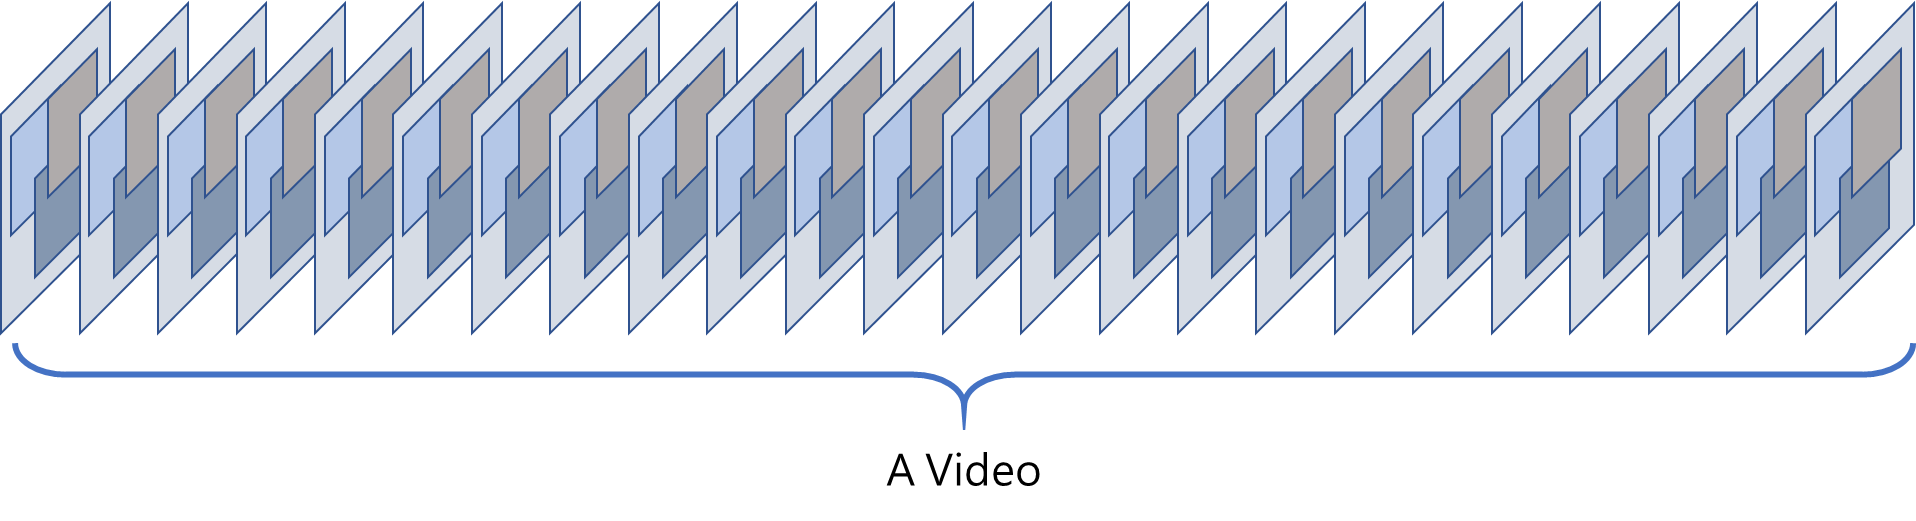

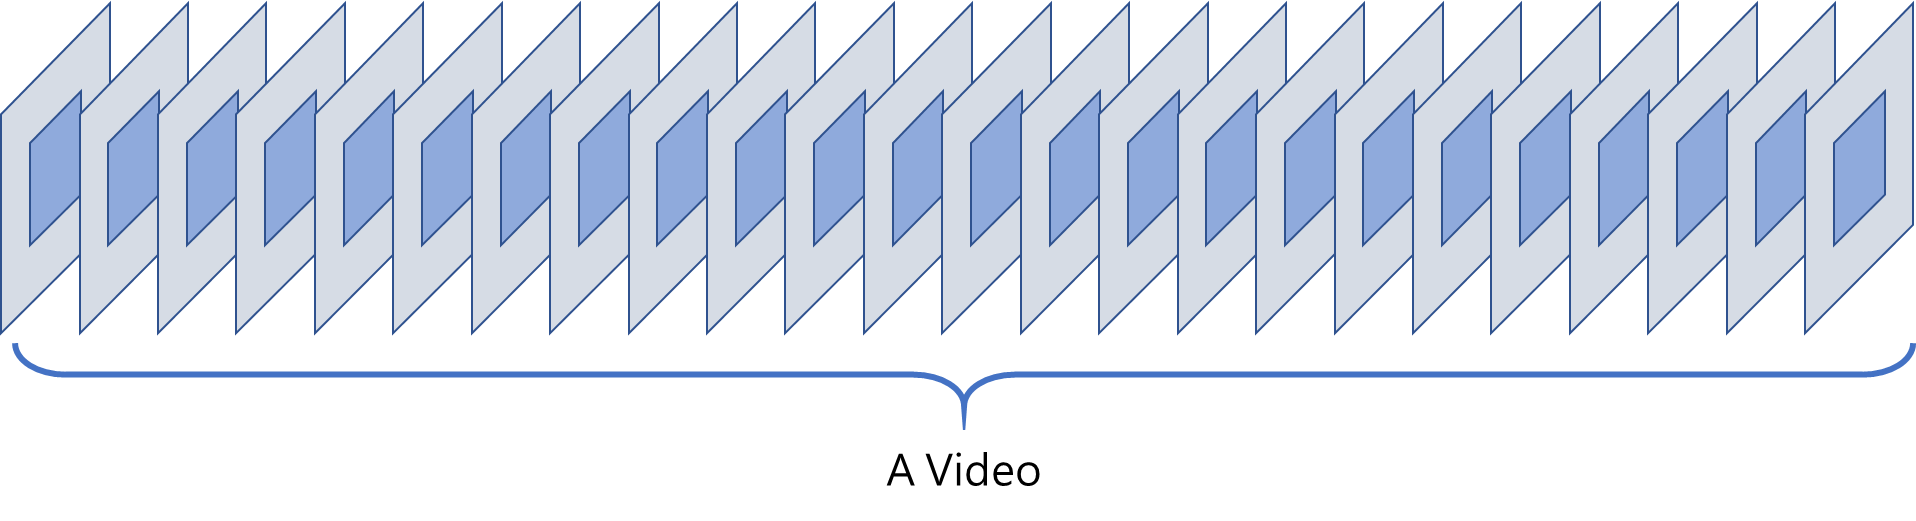

In [4]:
#@title 資料Augmentation、讀取資料、轉資料型態
class GroupRandomCrop:
    def __init__(self, size):
        self.size = (int(size), int(size)) if isinstance(size, int) else size

    def __call__(self, img_group):
        w, h = img_group[0].size
        th, tw = self.size
        x1 = random.randint(0, w - tw)
        y1 = random.randint(0, h - th)
        return [img.crop((x1, y1, x1 + tw, y1 + th)) for img in img_group]


class GroupCenterCrop:
    def __init__(self, size):
        self.size = size

    def __call__(self, img_group):
        return [transforms.CenterCrop(self.size)(img) for img in img_group]


class GroupRandomHorizontalFlip:
    def __init__(self, is_flow=False):
        self.is_flow = is_flow

    def __call__(self, img_group):
        if random.random() < 0.5:
            flipped = [img.transpose(Image.FLIP_LEFT_RIGHT) for img in img_group]
            if self.is_flow:
                for i in range(0, len(flipped), 2):
                    flipped[i] = ImageOps.invert(flipped[i])
            return flipped
        return img_group


class GroupScale:
    def __init__(self, size):
        self.size = size

    def __call__(self, img_group):
        return [transforms.Resize(self.size, interpolation=InterpolationMode.BILINEAR)(img) for img in img_group]


class Stack:
    def __init__(self, roll=False):
        self.roll = roll

    def __call__(self, img_group):
        # Convert PIL to tensor first, shape (C, H, W)
        img_group = [transforms.ToTensor()(img) for img in img_group]
        # Concatenate along time (frame) dimension
        return torch.cat(img_group, dim=0)


class GroupNormalize:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def __call__(self, tensor):
        c = tensor.size(0)
        rep_mean = self.mean.repeat(c // 3, 1, 1)
        rep_std = self.std.repeat(c // 3, 1, 1)
        return (tensor - rep_mean) / rep_std

class GroupApplyTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img_group):
        return [self.transform(img) for img in img_group]


def train_transforms():
    return transforms.Compose([
        GroupScale((256, 256)),
        GroupRandomCrop(224),
        # GroupApplyTransform(AutoAugment(policy=AutoAugmentPolicy.IMAGENET)),
        GroupRandomHorizontalFlip(),
        Stack(),
        GroupNormalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

def val_transforms():
    return transforms.Compose([
        GroupScale((224, 224)),
        GroupCenterCrop(224),
        Stack(),
        GroupNormalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

### 資料取樣方式

* 一整個影片會切成幾段：Num_clips == Num_segments
* 每一段影片中取樣的總長度：Clip_len == New_length
* 每一段影片中，每次隔多少的間隔選取一張影像：frame_interval

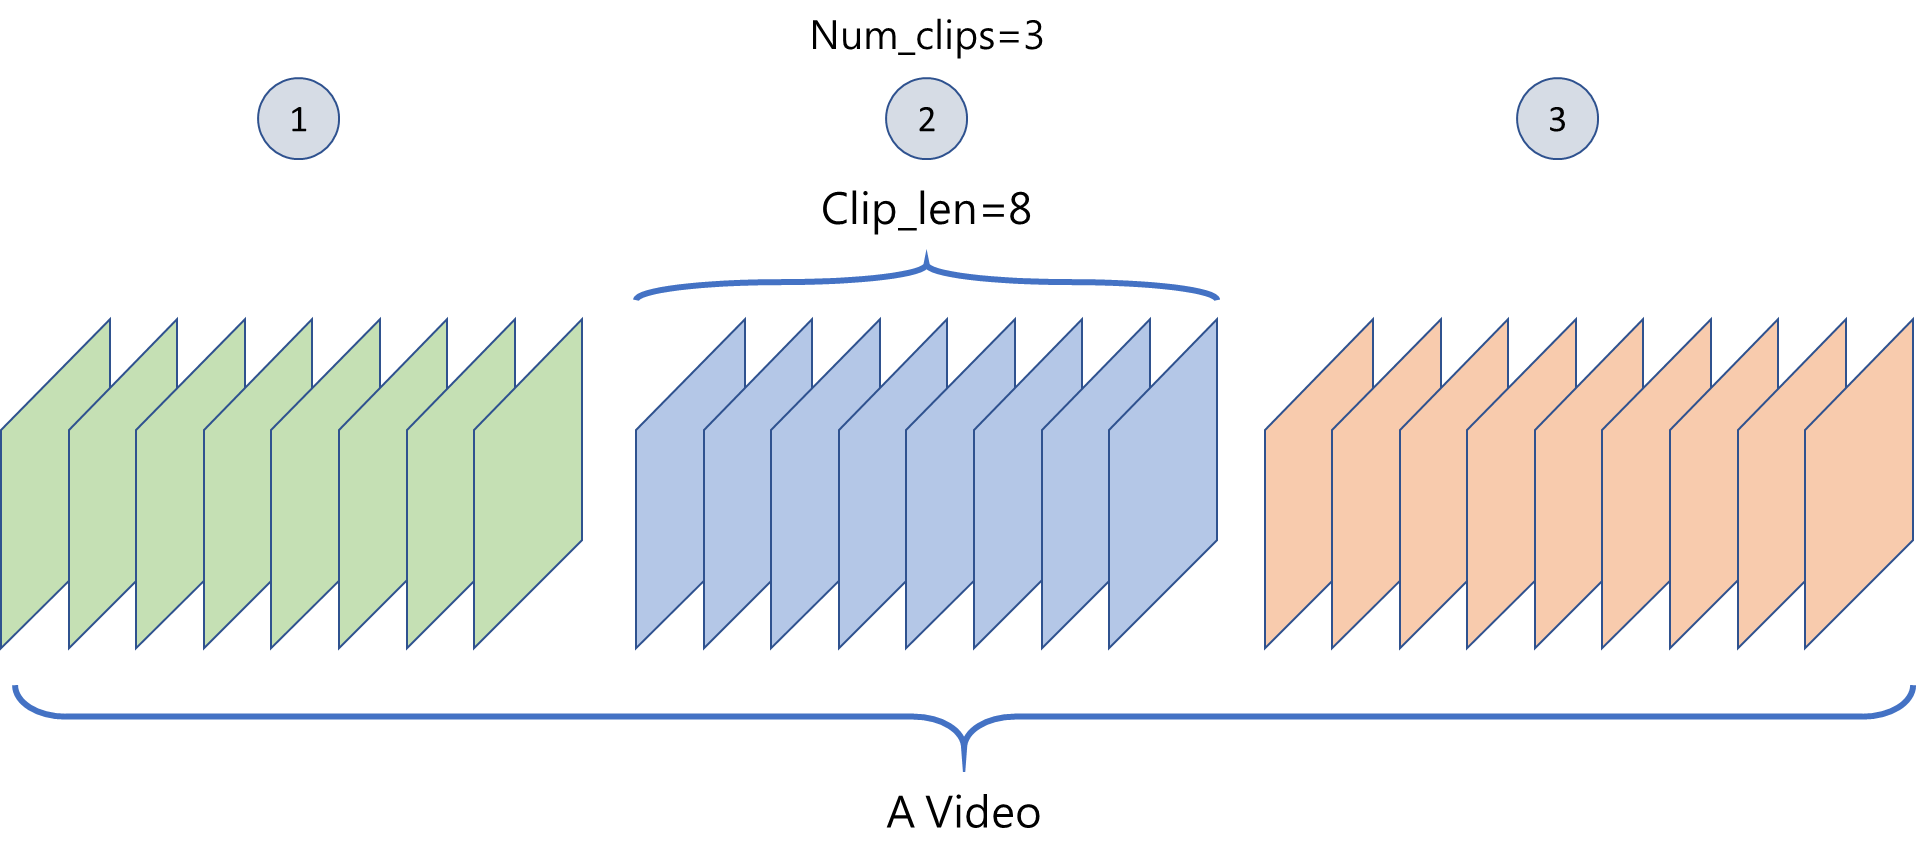

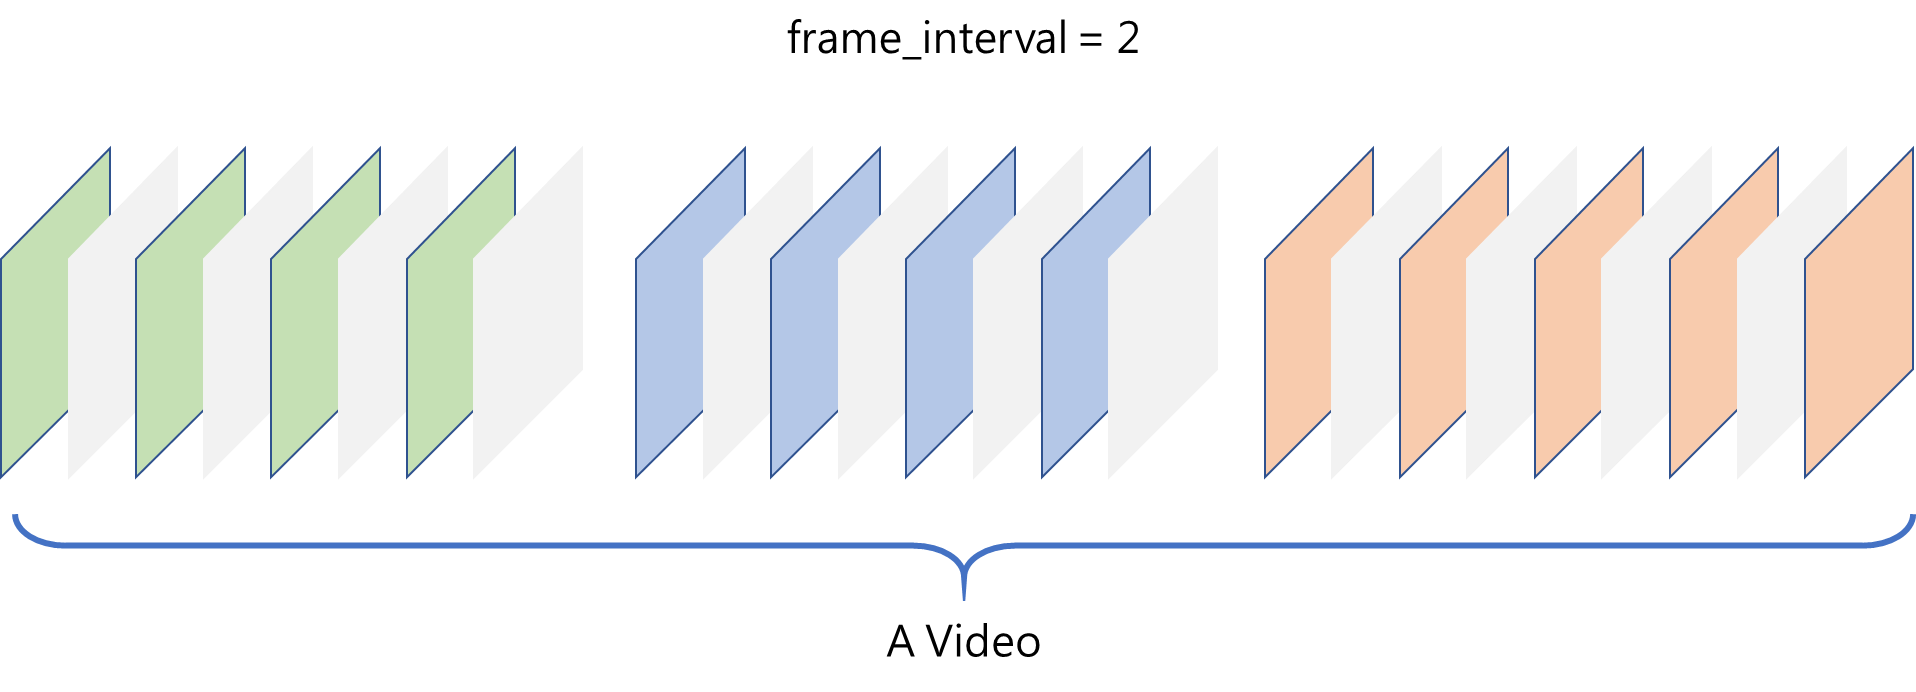

In [5]:
#@title Pytorch Dataset

"""
new_length 是指每個video中 每個segment 的長度
num_segments 是指每個video中 要分成幾段
frame_interval 是指每個segment中frame的間隔
"""

class BaseballDataset(Dataset):
    def __init__(self, data_path, labels_file, new_length=8, num_segments=8, frame_interval=1, transform=None):
        self.data_path = Path(data_path)
        self.labels = pd.read_csv(labels_file, header=None, sep=" ", names=["video", "length", "label"]).set_index("video")
        self.video_names = self.labels.index.to_list()
        self.new_length = new_length
        self.num_segments = num_segments
        self.frame_interval = frame_interval
        self.transform = transform

    def _sample_indices(self, total_frames):
        total_segment_span = self.frame_interval * (self.new_length - 1) + 1
        average_duration = (total_frames - total_segment_span + 1) // self.num_segments
        if average_duration > 0:
            offsets = np.multiply(list(range(self.num_segments)), average_duration) + \
                      np.random.randint(average_duration, size=self.num_segments)
        elif total_frames > self.num_segments * total_segment_span:
            max_offset = total_frames - total_segment_span
            offsets = np.sort(np.random.randint(max_offset, size=self.num_segments))
        else:
            offsets = np.zeros((self.num_segments,), dtype=int)
        return offsets

    def _extract_frames(self, video_path, total_frames):
        try:
            vr = VideoReader(str(video_path), ctx=cpu(0))
        except Exception as e:
            print(f"[ERROR] Failed to open video: {video_path} | {e}")
            return [Image.new("RGB", (224, 224)) for _ in range(self.new_length * self.num_segments)]

        indices = []
        for offset in self._sample_indices(total_frames):
            indices += [offset + i * self.frame_interval for i in range(self.new_length)]
        indices = [min(i, total_frames - 1) for i in indices]

        frames = []
        for idx in indices:
            idx = int(min(idx, total_frames - 1))  # 強制轉 int
            try:
                img = vr[idx].asnumpy()  # shape: (H, W, C)
                img = Image.fromarray(img)
                frames.append(img)
            except Exception as e:
                print(f"[WARN] Failed to load frame {idx}: {e}")
                frames.append(Image.new("RGB", (224, 224)))
        return frames

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        video_name = self.video_names[idx]
        item = self.labels.iloc[idx]
        total_frames = item.length
        video_path = self.data_path / f"{video_name}.mp4"
        frames = self._extract_frames(video_path, total_frames)

        if self.transform:
            frames = self.transform(frames)
        return frames, item.label

# 🤖📈 訓練

In [6]:
#@title 打印到畫面上的工具
class _ColorfulFormatter(logging.Formatter):
    def __init__(self, *args, **kwargs):
        self._root_name = kwargs.pop("root_name") + "."
        self._abbrev_name = kwargs.pop("abbrev_name", "")
        if len(self._abbrev_name):
            self._abbrev_name = self._abbrev_name + "."
        super(_ColorfulFormatter, self).__init__(*args, **kwargs)

    def formatMessage(self, record):
        record.name = record.name.replace(self._root_name, self._abbrev_name)
        log = super().formatMessage(record)
        # log = super(_ColorfulFormatter, self).formatMessage(record)
        if record.levelno == logging.WARNING:
            prefix = colored("WARNING", "red", attrs=["blink"])
        elif record.levelno == logging.ERROR or record.levelno == logging.CRITICAL:
            prefix = colored("ERROR", "red", attrs=["blink", "underline"])
        else:
            return log
        return prefix + " " + log


# so that calling setup_logger multiple times won't add many handlers
@functools.lru_cache()
def setup_logger(
    output=None, distributed_rank=0, *, color=True, name="moco", abbrev_name=None
):
    """
    Initialize the detectron2 logger and set its verbosity level to "INFO".
    Args:
        output (str): a file name or a directory to save log. If None, will not save log file.
            If ends with ".txt" or ".log", assumed to be a file name.
            Otherwise, logs will be saved to `output/log.txt`.
        name (str): the root module name of this logger
    Returns:
        logging.Logger: a logger
    """
    logger = logging.getLogger(name)
    logger.setLevel(logging.DEBUG)
    logger.propagate = False

    if abbrev_name is None:
        abbrev_name = name

    plain_formatter = logging.Formatter(
        "[%(asctime)s] %(name)s %(levelname)s: %(message)s", datefmt="%m/%d %H:%M:%S"
    )
    # stdout logging: master only
    if distributed_rank == 0:
        ch = logging.StreamHandler(stream=sys.stdout)
        ch.setLevel(logging.DEBUG)
        if color:
            formatter = _ColorfulFormatter(
                colored("[%(asctime)s %(name)s]: ", "green") + "%(message)s",
                datefmt="%m/%d %H:%M:%S",
                root_name=name,
                abbrev_name=str(abbrev_name),
            )
        else:
            formatter = plain_formatter
        ch.setFormatter(formatter)
        logger.addHandler(ch)

    # file logging: all workers
    if output is not None:
        if output.endswith(".txt") or output.endswith(".log"):
            filename = output
        else:
            filename = os.path.join(output, "log.txt")
        if distributed_rank > 0:
            filename = filename + f".rank{distributed_rank}"
        os.makedirs(os.path.dirname(filename), exist_ok=True)

        fh = logging.StreamHandler(_cached_log_stream(filename))
        fh.setLevel(logging.DEBUG)
        fh.setFormatter(plain_formatter)
        logger.addHandler(fh)

    return logger


# cache the opened file object, so that different calls to `setup_logger`
# with the same file name can safely write to the same file.
@functools.lru_cache(maxsize=None)
def _cached_log_stream(filename):
    return open(filename, "a")

In [7]:
#@title 計算準確率的工具
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1, )):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def confusion_matrix(output, target, topk=(1,), cf_matrix=None):
    maxk = max(topk)

    _, pred = output.topk(maxk, 1, True, False)
    pred = pred.t()[0] # for top1

    for i, j in zip(pred, target):
        cf_matrix[int(i.item()), j.item()] += 1

    return cf_matrix

In [8]:
#@title 儲存訓練好的權重
def save_checkpoint(state, epoch, is_best=False):
    ckpt_dir = Path("./checkpoint/Train_Mobilev4TSM")
    ckpt_dir.mkdir(parents=True, exist_ok=True)

    filename = ckpt_dir / f"{epoch}_epoch_ckpt.pth.tar"
    torch.save(state, filename)

    if is_best:
        best_filename = ckpt_dir / "best.pth.tar"
        torch.save(state, best_filename)

    total_list = list(ckpt_dir.glob("*_ckpt.pth.tar"))
    if len(total_list) > 5:
        total_list = sorted(total_list, key=lambda x: x.stat().st_mtime)
        total_list[0].unlink()

In [9]:
#@title 讀取訓練好的權重
def load_model(model, weight, logger):
    logger.info("=> fine-tuning from '{}'".format(weight))
    ckpt = torch.load(weight, weights_only=True)
    sd = ckpt['state_dict'] if 'state_dict' in ckpt else ckpt
    model_dict = model.state_dict()

    replace_dict = []
    for k, v in sd.items():
        if k not in model_dict and k.replace('.net', '') in model_dict:
            logger.info('=> Load after remove .net: {}'.format(k))
            replace_dict.append((k, k.replace('.net', '')))
    for k in model_dict:
        if k not in sd and k.replace('.net', '') in sd:
            logger.info('=> Load after adding .net: {}'.format(k))
            replace_dict.append((k.replace('.net', ''), k))

    for k, k_new in replace_dict:
        sd[k_new] = sd.pop(k)

    # Drop incompatible shapes
    filtered_sd = {}
    for k, v in sd.items():
        if k in model_dict and v.shape == model_dict[k].shape:
            filtered_sd[k] = v
        # else:
        #     logger.info(f"=> Skip loading parameter: {k}, shape mismatch {v.shape} vs {model_dict.get(k, None)}")

    model.load_state_dict(filtered_sd, strict=False)
    return model

In [10]:
#@title 參數
epochs = 5 # 總共要訓練幾個回合
new_length = 3
num_segments = 8
frame_interval = 2
batch_size = 32 # 一次丟進去模型的影片數量
num_workers = 0 # 一次要指派幾個員工來讀取資料跟做資料前處理，windows 系統建議用0
num_classes = 2 # 欲判斷類別數量

is_best = False
best_prec1 = 0
less_loss = 100000

# 固定初始化隨機種子，方便實驗重現結果
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

root = "./"
logger = setup_logger(output= root + "logs", name="Mobilev4TSM")
logger.info('storing name: ' + root + "Train_Mobilev4TSM")

# 優化器和損失函數及模型
model = MobileNetV4TSMInflated(num_segments=num_segments, new_length=new_length, num_classes=num_classes).cuda()

# load pre-trained
model = load_model(model, "./pre-trained/baseball_pretrained_best.pth.tar", logger)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

[07/10 17:14:52 Mobilev4TSM]: storing name: ./Train_Mobilev4TSM
[07/10 17:14:52 Mobilev4TSM]: => fine-tuning from './pre-trained/baseball_pretrained_best.pth.tar'


In [11]:
#@title 準備資料集和數據加載器
train_dataset = BaseballDataset(root + "clips/", root + "label_frames.txt", new_length, num_segments, frame_interval, transform=train_transforms())
val_dataset = BaseballDataset(root + "clips/", root + "label_frames.txt", new_length, num_segments, frame_interval, transform=val_transforms())
test_dataset = BaseballDataset(root + "clips/", root + "label_test.txt", new_length, num_segments, frame_interval, transform=val_transforms())
total_len = len(train_dataset)
train_len = int(0.8 * total_len)
val_len = total_len - train_len
generator = torch.Generator().manual_seed(0)

train_dataset, _ = random_split(train_dataset, [train_len, val_len], generator=generator)
_, val_dataset = random_split(val_dataset, [train_len, val_len], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=True)

In [12]:
def train(epoch):
    with torch.no_grad():
        losses = AverageMeter()
        top1 = AverageMeter()
        top5 = AverageMeter()

    model.train()

    logger.info(f"Start")
    for i, (inputs, target) in enumerate(train_loader):
        optimizer.zero_grad()

        inp = inputs.view((-1, inputs.shape[1] // num_segments) + (inputs.shape[2::]))
        inp = inp.cuda()
        target = target.cuda()

        output = model(inp)
        loss = criterion(output, target)

        prec1, prec5 = accuracy(output.data, target, (1, 2))

        with torch.no_grad():
            losses.update(loss.item(), inp.size(0))
            top1.update(prec1.item(), inp.size(0))
            top5.update(prec5.item(), inp.size(0))

        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), 10)

        optimizer.step()

        if i % 20 == 0:
            logger.info(('Epoch: [{0}][{1}/{2}],'
                        'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                        'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                        'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                            epoch, i, len(train_loader), loss=losses,
                            top1=top1, top5=top5, )))
    return losses.avg, top1.avg, top5.avg

In [13]:
def validate():
    with torch.no_grad():
        model.eval()
        cf_matrix = torch.zeros((num_classes, num_classes), dtype=torch.int64)
        losses = AverageMeter()
        top1 = AverageMeter()
        top5 = AverageMeter()

        for i, (inputs, target) in enumerate(val_loader):
            inp = inputs.view((-1, inputs.shape[1] // num_segments) + (inputs.shape[2::]))
            inp = inp.cuda()
            target = target.cuda()

            output = model(inp)
            loss = criterion(output, target)
            cf_matrix = confusion_matrix(output, target, cf_matrix=cf_matrix)

            prec1, prec5 = accuracy(output.data, target, (1, 2))

            losses.update(loss.item(), inp.size(0))
            top1.update(prec1.item(), inp.size(0))
            top5.update(prec5.item(), inp.size(0))

            if i % 20 == 0:
                logger.info(
                    ('Test: [{0}/{1}]\t'
                    'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                    'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                    'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                        i, len(val_loader), loss=losses, top1=top1, top5=top5))) # , batch_time=batch_time
    logger.info(('Testing Results: Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f} Loss {loss.avg:.5f}'
        .format(top1=top1, top5=top5, loss=losses)))
    logger.info(f"Confusion Matrix: \n{cf_matrix}")

    return top1.avg, top5.avg, losses.avg

In [ ]:
#@title 正式訓練
for epoch in range(epochs):
    train_loss, train_top1, train_top5 = train(epoch)
    if (epoch + 1) % 1 == 0 or epoch == epochs - 1:
        prec1, prec5, val_loss = validate()
        if prec1 > best_prec1:
            is_best = True
            less_loss = val_loss
            best_prec1 = prec1
        elif prec1 == best_prec1:
            is_best = val_loss < less_loss
            best_prec1 = prec1
        else:
            is_best = False
        logger.info(("Best Prec@1: '{}'".format(best_prec1)))
        save_epoch = epoch + 1
        save_checkpoint(
            {
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'prec1': prec1,
                'best_prec1': best_prec1,
            }, save_epoch)
logger.info("Train_Mobilev4TSM" + "\n" + f"Best Prec@1: {best_prec1}")

[07/10 16:41:27 Mobilev4TSM]: Start
[07/10 16:41:30 Mobilev4TSM]: Epoch: [0][0/144],Loss 0.6465 (0.6465)	Prec@1 65.625 (65.625)	Prec@5 100.000 (100.000)
[07/10 16:42:12 Mobilev4TSM]: Epoch: [0][20/144],Loss 0.6212 (0.6729)	Prec@1 71.875 (60.119)	Prec@5 100.000 (100.000)
[07/10 16:42:54 Mobilev4TSM]: Epoch: [0][40/144],Loss 0.5273 (0.6466)	Prec@1 75.000 (64.558)	Prec@5 100.000 (100.000)
[07/10 16:43:40 Mobilev4TSM]: Epoch: [0][60/144],Loss 0.5648 (0.6161)	Prec@1 71.875 (68.135)	Prec@5 100.000 (100.000)
[07/10 16:44:25 Mobilev4TSM]: Epoch: [0][80/144],Loss 0.5759 (0.5985)	Prec@1 62.500 (69.329)	Prec@5 100.000 (100.000)
[07/10 16:45:10 Mobilev4TSM]: Epoch: [0][100/144],Loss 0.4840 (0.5848)	Prec@1 75.000 (69.957)	Prec@5 100.000 (100.000)
[07/10 16:45:57 Mobilev4TSM]: Epoch: [0][120/144],Loss 0.6667 (0.5727)	Prec@1 59.375 (70.739)	Prec@5 100.000 (100.000)
[07/10 16:46:42 Mobilev4TSM]: Epoch: [0][140/144],Loss 0.7809 (0.5665)	Prec@1 59.375 (71.077)	Prec@5 100.000 (100.000)
[07/10 16:46:50 Mo

* 以下是訓練 60 epochs 的結果，並且有加入一些模型訓練技巧的 準確率 以及 損失函數圖

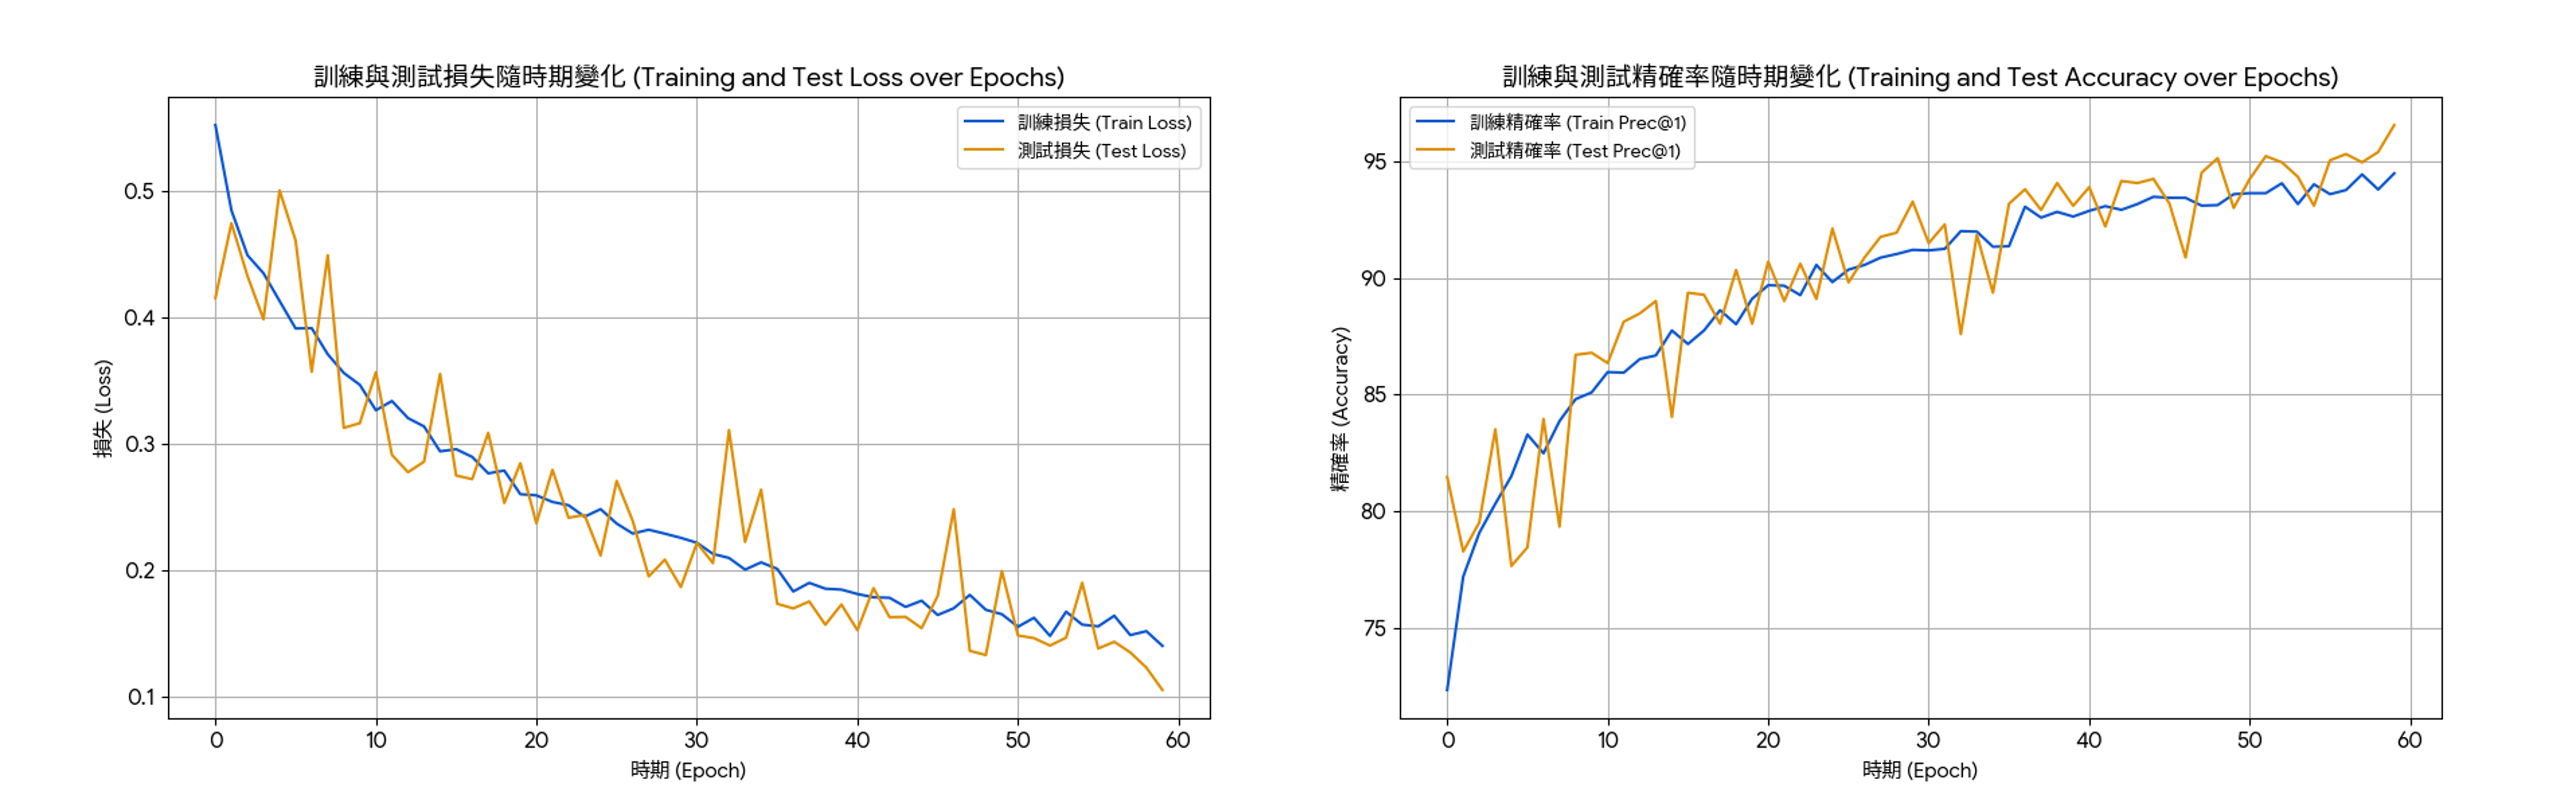

In [14]:
import io
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from IPython.display import display, Image as IPImage

imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
imagenet_std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
def visualize_segments_with_new_length(sample, num_segments, new_length, class_pred, class_true, class_names):
    """
    sample: Tensor [T, C, H, W], 其中 T = num_segments × new_length
    """
    total_frames = num_segments * new_length
    assert sample.shape[0] == total_frames

    frames = []
    for seg in range(num_segments):
        for l in range(new_length):
            idx = seg * new_length + l
            img = sample[idx].cpu()
            img = img * imagenet_std + imagenet_mean  # 反標準化
            img = torch.clamp(img, 0, 1)
            img = F.to_pil_image(img)
            frames.append(img)

    # 儲存為 GIF 到記憶體中
    gif_buffer = io.BytesIO()
    frames[0].save(gif_buffer, format='GIF', save_all=True, append_images=frames[1:], duration=150, loop=0)
    gif_buffer.seek(0)

    # 顯示 GIF
    display(IPImage(data=gif_buffer.read()))

模型的預測: tensor([0], device='cuda:0'), 真實答案: tensor([0], device='cuda:0')


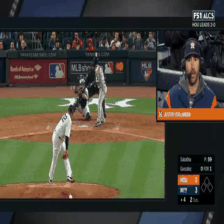

模型的預測: tensor([0], device='cuda:0'), 真實答案: tensor([0], device='cuda:0')


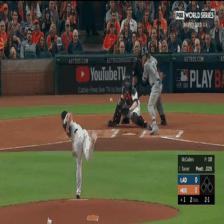

模型的預測: tensor([0], device='cuda:0'), 真實答案: tensor([0], device='cuda:0')


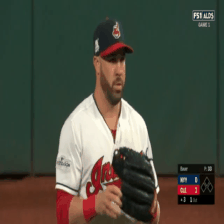

模型的預測: tensor([0], device='cuda:0'), 真實答案: tensor([0], device='cuda:0')


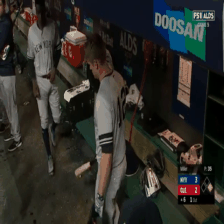

In [15]:
#@title 測試
model.eval()
maxk = 1
class_names = {0:"N", 1:"swing"}
with torch.no_grad():
    for i, (inputs, target) in enumerate(test_loader):
        # 假設 inputs: [B, T_L, C, H, W] where T_L = num_segments * new_length
        inp = inputs.view((-1, inputs.shape[1] // num_segments) + inputs.shape[2:])  # [B*num_segments, new_length, C, H, W]
        inp = inp.cuda()
        target = target.cuda()

        output = model(inp)
        _, pred = output.topk(maxk, 1, True, False)
        pred = pred.t()[0]

        print(f"模型的預測: {pred}, 真實答案: {target}")

        # 可視化第一筆
        sample = inputs[0]  # [T, C, H, W], T = num_segments * new_length
        sample = sample.view((num_segments * new_length, -1) + inputs.shape[2:])
        visualize_segments_with_new_length(
            sample,
            num_segments=num_segments,
            new_length=new_length,
            class_pred=pred[0].item(),
            class_true=target[0].item(),
            class_names=class_names
        )

        if i >= 3:
            break